# Project Part 2 Solutions

Jay Patwardhan, Shivam Misra, Vikram Pasupathy

## (a)

In [ ]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

In [ ]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))


def loss_func(alpha):
    
    ###### WRITE YOUR FUNCTION HERE
    Snew = S[node_index,:,:,9].flatten()
    Inew = I[node_index,:,9]
    Rnew = np.array([R[node_index][9]])
    beta_new = alpha*beta_old
    Ic = np.concatenate((Snew, Inew, Rnew))

    ans = solve_ivp(SIR, (t[10], t[29]), Ic, args=(N_node, beta_new, gamma), t_eval=t[10:30])
    

   
    L[node_index, 10:30] = Lc@ans.y[16:20]
    L_truth = L_observed[node_index, 10:30]
    mse = mean_squared_error(L[node_index,10:30],L_truth)


    return mse


for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)


In [ ]:
print(alpha_predicted)

[0.22669983 0.39484253 0.22185059 0.73707123 0.70143738 0.20029602
 0.35754395 0.35007172 0.3601532  0.16713867 0.27568665 0.32045898
 0.31580811 0.20931396 0.12352142 0.22246094 0.18051758 0.56386719
 0.59924927 0.14249268 0.26811523 0.27178955 0.49281006 0.26390381
 0.33642883 0.15171814 0.3757782  0.21018066 0.44144897 0.68422394
 0.29797363 0.3010498  0.39297028 0.16387329 0.61907349 0.66160202
 0.3225708  0.15137939 0.28189697 0.90992126 0.41170807 0.43126221
 0.43154907 0.17045288 0.24889221 0.41756592 0.71300049 0.330896
 0.23173828 0.20965576 0.13822021 0.20452881 0.33418884 0.26639404
 0.14807129 0.66747131 0.17644043 0.53582764 0.27561264 0.56835938
 0.36387939 0.27543945 0.34067383 0.42473755 0.24645996 0.52313232
 0.20018311 0.38779907 0.46865234 0.1552803  0.14443359 0.33525391
 0.2932373  0.44838867 0.41690369 0.30296936 0.56982422 0.66409302
 0.37408447 0.20103149 0.32358704 0.51626587 0.72009888 0.35155029
 0.28358765 0.28780823 0.25011292 0.54241028 0.98475342 0.517907

I have now found the alpha values for all 100 nodes, and I will sort the nodes and rank them.

In [ ]:
store = {}
counter = 1
for i in alpha_predicted:
    store[f'Node {counter}: '] = i
    counter+=1

store = sorted(store.items(), key=lambda x: x[1])

print('Nodes ranked by alpha values:')
for i in store:
    print(i[0], i[1])

Nodes ranked by alpha values:
Node 15:  0.12352142333984342
Node 51:  0.1382202148437497
Node 20:  0.1424926757812497
Node 71:  0.14443359374999967
Node 97:  0.14606933593749968
Node 55:  0.1480712890624997
Node 38:  0.15137939453124966
Node 26:  0.15171813964843717
Node 70:  0.15528030395507786
Node 34:  0.16387329101562467
Node 91:  0.16503143310546842
Node 10:  0.1671386718749997
Node 44:  0.17045288085937468
Node 57:  0.1764404296874997
Node 17:  0.18051757812499974
Node 96:  0.19622192382812473
Node 67:  0.20018310546874973
Node 6:  0.20029602050781226
Node 80:  0.20103149414062474
Node 52:  0.20452880859374978
Node 14:  0.20931396484374976
Node 50:  0.20965576171874978
Node 28:  0.21018066406249977
Node 3:  0.22185058593749976
Node 16:  0.2224609374999998
Node 94:  0.22650146484374978
Node 1:  0.22669982910156228
Node 49:  0.23173828124999976
Node 99:  0.23728027343749977
Node 65:  0.24645996093749978
Node 45:  0.2488922119140623
Node 87:  0.2501129150390623
Node 93:  0.257067871

In [ ]:
print(L[0,29])

2199.986360101904


## (b) 

We will find the difference bu subtracting the number of recovered/succumbed people after 200 days if there was no NPI from the number of recovered/succumbed after 200 days if there is an NPI.

In [ ]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    ###### WRITE YOUR FUNCTION HERE
    beta_after = beta_old*alpha_afterNPI

    Sn = S[node_index,:,:,29].flatten()
    In = I[node_index,:,29]
    Rn = np.array([R[node_index][29]])
    Ic_new = np.concatenate((Sn, In, Rn))

    ans_n = solve_ivp(SIR, (t[30], t[199]), Ic_new, args=(N_node, beta_after, gamma), t_eval=t[30:200])
    #new recovered/succumbed values
    Rcomp[node_index, :170] = ans_n.y[20]


    difference = Rcomp[node_index, -1] - R[node_index][-1]


    
    return difference

In [ ]:
#compute R after 10-2-- with our optimal alphas
for N_node, node_index in zip(N, range(nb_nodes)):
    use_betas = beta_old*alpha_predicted[node_index]
    Snew = S[node_index,:,:,9].flatten()
    Inew = I[node_index,:,9]
    Rnew = np.array([R[node_index][9]])
    Ic = np.concatenate((Snew, Inew, Rnew))

    ans = solve_ivp(SIR, (t[10], t[199]), Ic, args=(N_node, use_betas, gamma), t_eval=t[10:200])

    S[node_index,:,:,10:200] = ans.y[:16].reshape(4, 4, -1)
    I[node_index,:,10:200] = ans.y[16:20]
    R[node_index,10:200] = ans.y[20]



### Policy #1

i. We will now make the corresponding scatter plot for the 100 nodes. In this policy, each node will be allocated 10,000 dollars.

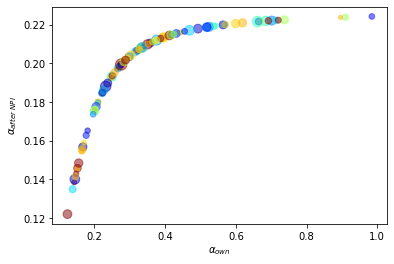

In [ ]:
#get the alpha after NPI's with our given policy
import matplotlib.pyplot as plt
alphas_after_NPI = []
amount_per = 10000

for N_node, node_index in zip(N, range(nb_nodes)):
    new_alpha = g(g_inv(alpha_predicted[node_index]) + amount_per)
    alphas_after_NPI.append(new_alpha)


scatter_plot(alphas_after_NPI)

ii. We will now find the difference between NPI and no NPI. Again in this policy each node is allocated $10,000.

In [ ]:
amount_per = 10000
Rcomp = np.zeros((100,170))
differences = []
for N_node, node_index in zip(N, range(nb_nodes)):
    new_alpha = g(g_inv(alpha_predicted[node_index]) + amount_per)
    differences.append(total_recovered_difference(new_alpha))

total_difference = int(np.sum(differences))
print('The difference in recovered population between NPI and no NPI is: ',total_difference)

The difference in recovered population between NPI and no NPI is:  -329893


### Policy #2

i. Here we need to figure out the new alpha values by allocating the budget according to the proportion between the node's population and the total population. Then we will graph the results.

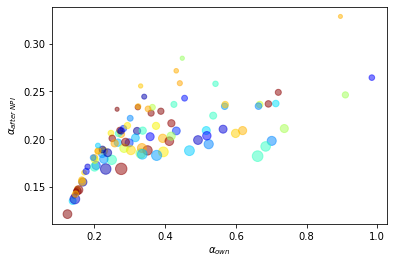

In [ ]:
alphas_after_NPI = []
total_fund = 1000000
total_population = np.sum(N)


for N_node, node_index in zip(N, range(nb_nodes)):
    proportion = N[node_index]/total_population
    allocated_fund = total_fund*proportion
    new_alpha = g(g_inv(alpha_predicted[node_index]) + allocated_fund)
    alphas_after_NPI.append(new_alpha)

scatter_plot(alphas_after_NPI)

ii. We found the allocated funds for each node with this policy, and  stored them in an array called "funds". We can access these values of allocated funds to find the difference of recovered/succumbed people between NPI and no NPI after 200 days.

In [ ]:
Rcomp = np.zeros((100,170))
differences = []
for N_node, node_index in zip(N, range(nb_nodes)):
    differences.append(total_recovered_difference(alphas_after_NPI[node_index]))

total_difference = int(np.sum(differences))
print('The difference in recovered population between NPI and no NPI is: ',total_difference)

The difference in recovered population between NPI and no NPI is:  -346022


### Policy #3

First, we will focus on finding what this change in $\alpha$ should be for each node. Then we will induce that change and then do the two parts with the new alphas.

In [ ]:
def my_func(change):
    theSum = 0
    changed_array = alpha_predicted + change

    for i in range(len(changed_array)):
        theSum+=(g_inv(changed_array[i]) - g_inv(alpha_predicted[i]))

    return abs(1000000-theSum)


minn = fmin(my_func, 0.5, disp=False)


i. Now, we know the $\Delta \alpha$ we want to use from the previous code; it is stored in "minn". So we will apply this same $\Delta \alpha$ to each node and graph the results.

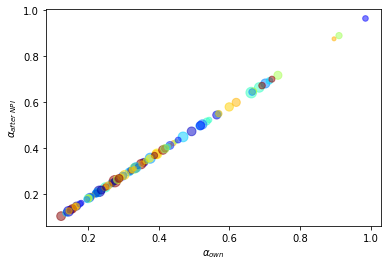

In [ ]:
current_new_alphas = alpha_predicted + minn[0]

scatter_plot(current_new_alphas)

ii. Based on our new alpha values, we will find the number of recorvered/succumbed people with this NPI policy implemented, and then compare it to recovered/succumbed people if there was no NPI policy, finding the difference for it as well.

In [ ]:
Rcomp = np.zeros((100,170))
differences = []
for N_node, node_index in zip(N, range(nb_nodes)):
    differences.append(total_recovered_difference(current_new_alphas[node_index]))

total_difference = int(np.sum(differences))
print('The difference in recovered population between NPI and no NPI is: ',total_difference)

The difference in recovered population between NPI and no NPI is:  -42357


### Policy #4

In this policy, we look at finding a way to measure the effect of our NPI and allow for optimization while remaining fair. 

i. In this policy, we will be looking at allocating budget proporptional to susceptible population per node during the initial condition. We will first count the total susceptible population from 100 nodes. Then, looking at the percentage per node of the susceptible population, we will divide the funds.

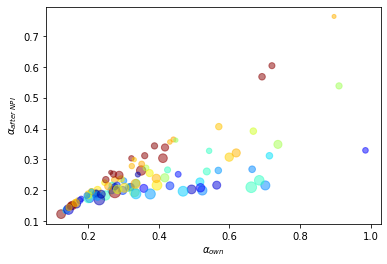

In [ ]:
#find total suseptible population of all 100 nodes
total = 0
for N_node, node_index in zip(N, range(nb_nodes)):
    s_init = np.sum(S[node_index,:,:,29].flatten())
    total+=s_init


#find the new alphas based on the given policy
total_funds = 1000000
alphas_after_NPI = []

for N_node, node_index in zip(N, range(nb_nodes)):
    s_init = np.sum(S[node_index,:,:,29].flatten())
    proportion = s_init/total_population
    allocated_fund = total_funds*proportion
    new_alpha = g(g_inv(alpha_predicted[node_index]) + allocated_fund)
    alphas_after_NPI.append(new_alpha)


#graph
scatter_plot(alphas_after_NPI)

ii.

In [ ]:
#take newly found alphas and find Recovered/succumbed values after NPI to compare to no-NPI values
Rcomp = np.zeros((100,170))
differences = []
for N_node, node_index in zip(N, range(nb_nodes)):
    differences.append(total_recovered_difference(alphas_after_NPI[node_index]))

total_difference = int(np.sum(differences))
print('The difference in recovered population between NPI and no NPI is: ',total_difference)

The difference in recovered population between NPI and no NPI is:  -306539


## (c) 

**Our measure on fairness:** The funding for NPI has a purpose of helping increase the awareness and precaution in a community to hopefully stop the spread of the disease. So, a fair way to allocate funds would be to allocate more funds to places taking less precaution and less funds to nodes taking more precaution. This is because, if maximum precaution is already being taken at a node, then a big NPI will not affect the rate of spread at that node since maximum precaution is already being taken. However an NPI at a low precaution node could increase awareness and cautiousness, and reduce the spread in those areas a lot more significantly.

So, to be fair, if two nodes nodes have similar $\alpha_{own}$ values, then the ratio of funding for the node to the number of suseptible people in the node should be similar. Furthermore, lower $\alpha_{own}$ valued nodes should be given more funds because the impact of an NPI could be greater here. This is a good measure of fairness because this ensures that the money spent per suseptible person in the NPI will be similar in cases where the $\alpha_{own}$ values are similar per node.

### Policy 1

I will make two graphs here. One that graphs $\alpha_{own}$ vs. funding allocated to the node, and one that measures $\alpha_{own}$ vs ratio of funding to suseptiple population at the node at day 30. I will use these to check if our measure of fairness holds.

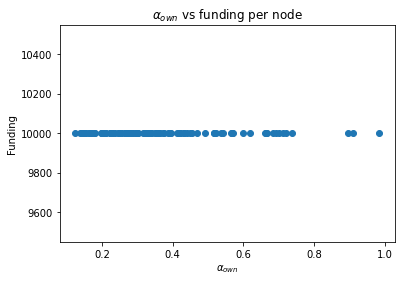

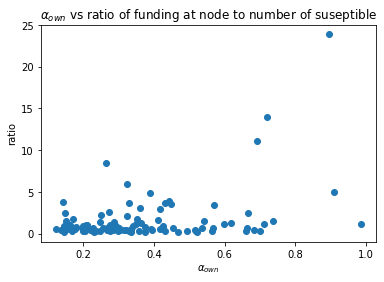

In [ ]:
import matplotlib.pyplot as plt

fundings = [10000 for i in range(100)]
plt.scatter(alpha_predicted, fundings)
plt.title(r'$\alpha_{own}$ vs funding per node')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'Funding')
plt.show()
 

ratios = []
for N_node, node_index in zip(N, range(nb_nodes)):
    ratios.append(fundings[node_index]/np.sum(S[node_index,:,:,29].flatten()))

plt.scatter(alpha_predicted, ratios)
plt.title(r'$\alpha_{own}$ vs ratio of funding at node to number of suseptible')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'ratio')
plt.show()


As we can see from the first graph, all the values of $\alpha_{own}$  have the same funding. Based on our measure of fairness, this makes this policy unfair because the nodes where less precaustion is taken recieve the same amount of NPI funding compared to the nodes where most NPI precaution is taken.

### Policy 2

We will repeat the above method for the following policies.

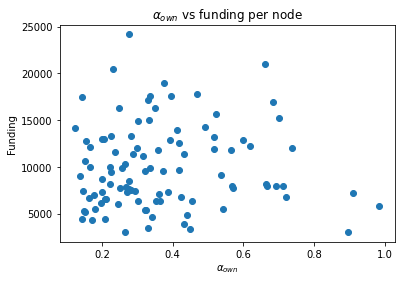

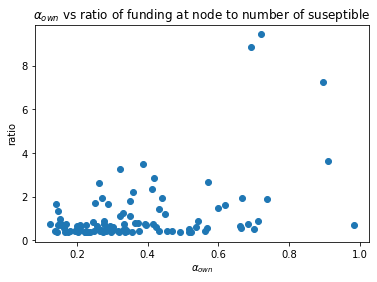

In [ ]:
import matplotlib.pyplot as plt

fundings = []

total_fund = 1000000
total_population = np.sum(N)


for N_node, node_index in zip(N, range(nb_nodes)):
    proportion = N[node_index]/total_population
    allocated_fund = total_fund*proportion
    fundings.append(allocated_fund)



plt.scatter(alpha_predicted, fundings)
plt.title(r'$\alpha_{own}$ vs funding per node')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'Funding')
plt.show()


ratios = []
for N_node, node_index in zip(N, range(nb_nodes)):
    ratios.append(fundings[node_index]/np.sum(S[node_index,:,:,29].flatten()))

plt.scatter(alpha_predicted, ratios)
plt.title(r'$\alpha_{own}$ vs ratio of funding at node to number of suseptible')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'ratio')
plt.show()


From the graphs it seems as though funding based on precaution level is not an idea that is followed here at all due to the scattered nature of the first graph. Therefore, this policy is not fair.

### Policy 3

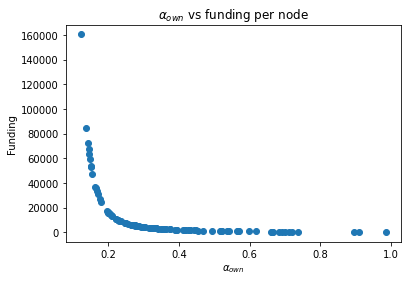

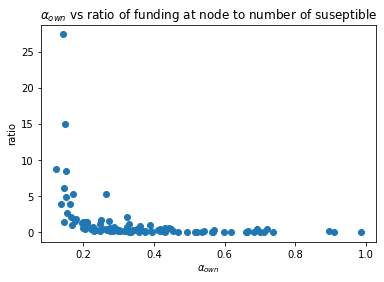

In [ ]:
def my_func(change):
    theSum = 0
    changed_array = alpha_predicted + change

    for i in changed_array:
        theSum+=g_inv(i)

    return abs(1000000-theSum)


minn = fmin(my_func, 0.5, disp=False)

current_new_alphas = alpha_predicted - minn[0]

fundings = []

for i in current_new_alphas:
    fundings.append(g_inv(i))

plt.scatter(alpha_predicted, fundings)
plt.title(r'$\alpha_{own}$ vs funding per node')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'Funding')
plt.show()


ratios = []
for N_node, node_index in zip(N, range(nb_nodes)):
    ratios.append(fundings[node_index]/np.sum(S[node_index,:,:,29].flatten()))

plt.scatter(alpha_predicted, ratios)
plt.title(r'$\alpha_{own}$ vs ratio of funding at node to number of suseptible')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'ratio')
plt.show()


Since bigger alpha values mean less precaution taken, here it seems as if less funding is allocated to places taking less precaution and more funding is allocated to places with less precaution. Therefore by our measure, this policy is not fair.

### Policy 4

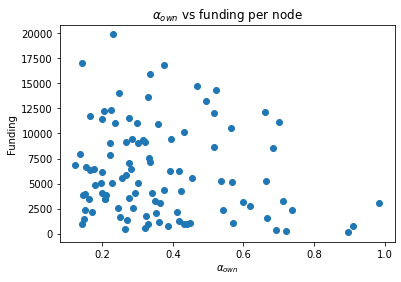

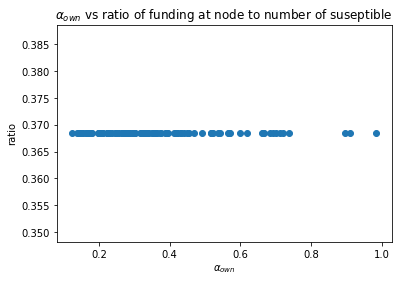

In [ ]:
#find total suseptible population of all 100 nodes
total = 0
for N_node, node_index in zip(N, range(nb_nodes)):
    s_init = np.sum(S[node_index,:,:,29].flatten())
    total+=s_init


#find the new alphas based on the given policy
total_funds = 1000000
alphas_after_NPI = []
fundings = []

for N_node, node_index in zip(N, range(nb_nodes)):
    s_init = np.sum(S[node_index,:,:,29].flatten())
    proportion = s_init/total_population
    allocated_fund = total_funds*proportion
    fundings.append(allocated_fund)

plt.scatter(alpha_predicted, fundings)
plt.title(r'$\alpha_{own}$ vs funding per node')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'Funding')
plt.show()


ratios = []
for N_node, node_index in zip(N, range(nb_nodes)):
    ratios.append(fundings[node_index]/np.sum(S[node_index,:,:,29].flatten()))

plt.scatter(alpha_predicted, ratios)
plt.title(r'$\alpha_{own}$ vs ratio of funding at node to number of suseptible')
plt.xlabel(r'$\alpha_{own}$')
plt.ylabel(r'ratio')
plt.show()

Here we can see that for similar values of $\alpha_{own}$, the ratios are similar, and from the first graph less precaution areas do recieve substantial funding. And if the less precaution area does not recieve as much or if the higher precaution area recieves more funding, it is because of the population sizes at the node, so the same amount of funding per suseptible person is still being spent however. 